In [1]:
import h5py
import numpy as np
def load_dataset(dataset_file):
        in_file = h5py.File(dataset_file, "r")
        traces = np.array(in_file['Profiling_traces/Traces'])
        # Ciphertext = np.array(in_file['Profiling_traces/Ciphertext'])
        # Secret_key = np.array(in_file['Profiling_traces/Secret_Key'])        
        # Shared_Key = np.array(in_file['Profiling_traces/Shared_Key'])
        NTT_in_coef = np.array(in_file['Profiling_traces/NTT_IN_Coefficients'])
        NTT_out_coef = np.array(in_file['Profiling_traces/NTT_OUT_Coefficients'])
        # Key_coin = np.array(in_file['Profiling_traces/Key_Generation_coin'])
        # enc_coin = np.array(in_file['Profiling_traces/Encapsulation_coin'])

        # return traces, Secret_key, Ciphertext, Shared_Key, NTT_in_coef, NTT_out_coef, Key_coin, enc_coin
        return traces, NTT_in_coef, NTT_out_coef

In [2]:
# traces, train_data, Secret_key, Ciphertext, Shared_Key, NTT_in_coef, NTT_out_coef, Key_coin, enc_coin = load_dataset('../dataset/Dataset_1.h5')
traces, ntt_in, ntt_out = load_dataset('../dataset/Dataset_1.h5')
print("Collected traces shape: ", str(traces.shape))
print("The input poly of ntt shape: ", ntt_in.shape)
print("The output poly of ntt shape: ", ntt_out.shape)
# 1536/3 = 512 = 256 * 2 bytes


Collected traces shape:  (50000, 10740)
The input poly of ntt shape:  (50000, 1536)
The output poly of ntt shape:  (50000, 1536)


In [6]:
from tqdm import trange

num_examples = traces.shape[0]
n = 256

# convert  two bytes into one coefficient
def convert_bytes_to_coeffs_ntt_in(arr):
    coeff = np.zeros(n*3, dtype=np.int16)
    HW = np.zeros(n*3, dtype=int)
    for j in range(n*3):
        if arr[2*j] == 255 and arr[2*j+1] == 255:
            coeff[j] = -1
            HW[j] = 16
        elif arr[2*j] == 254 and arr[2*j+1] == 255:
            coeff[j] = -2
            HW[j] = 15
        elif arr[2*j] == 0 and arr[2*j+1] == 0:
            coeff[j] = 0
            HW[j] = 0
        elif arr[2*j] == 1 and arr[2*j+1] == 0:
            coeff[j] = 1
            HW[j] = 1
        elif arr[2*j] == 2 and arr[2*j+1] == 0:
            coeff[j] = 2
            HW[j] = 2
        else:
            print("Error in converting bytes to coeffs")
            print(arr[2*j], arr[2*j+1])
            exit(-1)
    return coeff, HW
# print("First ntt input", ntt_in[0, 0:100])
# print("First ntt output", ntt_out[0, 0:40])
ntt_coeff_in = np.zeros((num_examples, n*3), dtype=np.int16)
HW_all = np.zeros((num_examples, n*3), dtype=int)
# for both variable each two bytes represent a single coefficient
for i in range(num_examples): 
    ntt_coeff_in[i], HW_all[i] = convert_bytes_to_coeffs_ntt_in(ntt_in[i])
print(ntt_coeff_in[0:10, :100])

[[ 1 -1 -1  1 -1  0  1  0  0 -1  1  0  0  2  0  1  2  0  0 -1 -1 -1  0  0
   0 -2  1 -1  0 -1  1  0  0  1  2  0 -1  1  0 -1  2 -1 -1  1 -1  0  0  1
  -1  1  0  0  0  1  1  1 -2  1 -1  1  1  0  1  1 -1  2 -2  0  0 -1 -1 -1
   1  1 -1 -1  1  2  1  1 -1  1  1  0  0  0  0 -1  1  1 -1 -1  2  1 -1  0
   1  0  1  1]
 [-1  0 -1  1 -1  1  0  0  0 -1  1 -2  0  1 -2 -1  0  1  0 -1  0 -2  2  0
   1  1  0  1  0  0  0  0  1  1  1  1 -1  0 -1 -2  0  1  0 -1  0  0  1  0
   2  2 -1  0  2 -1  1  1 -1 -1  0  1  0  0  1 -1  0 -1 -1  0 -1  2 -2 -1
   0 -2  1 -1 -1  0  0  1  0  1  0 -1  0  0  0  1  1 -1 -1  0 -1  0  1 -1
   0  0 -1  0]
 [ 2  0 -2  0 -1  0  0 -1 -1  2  0  1 -1  0  0  0 -1 -1  0  0  0 -1  0  0
   0 -1  0  0  0  0 -1 -1  1  0 -1 -1  2 -1  0  1  1  1  1  0  0  1 -2  0
  -1  0  1  0  0  0  1  1  1 -2  0 -2  1  0  1  0  1  1 -1  0  1 -2  1  0
   1  1 -1  1  0 -1 -2 -1 -1  0 -1  0 -2 -1 -1  0  0 -1 -1  2  0  0  1 -1
   0  1  0  0]
 [ 1  2 -1 -1  0  0  0 -1  0  1  0  1 -1 -1 -1 -1  0 -1  0  0  0  0

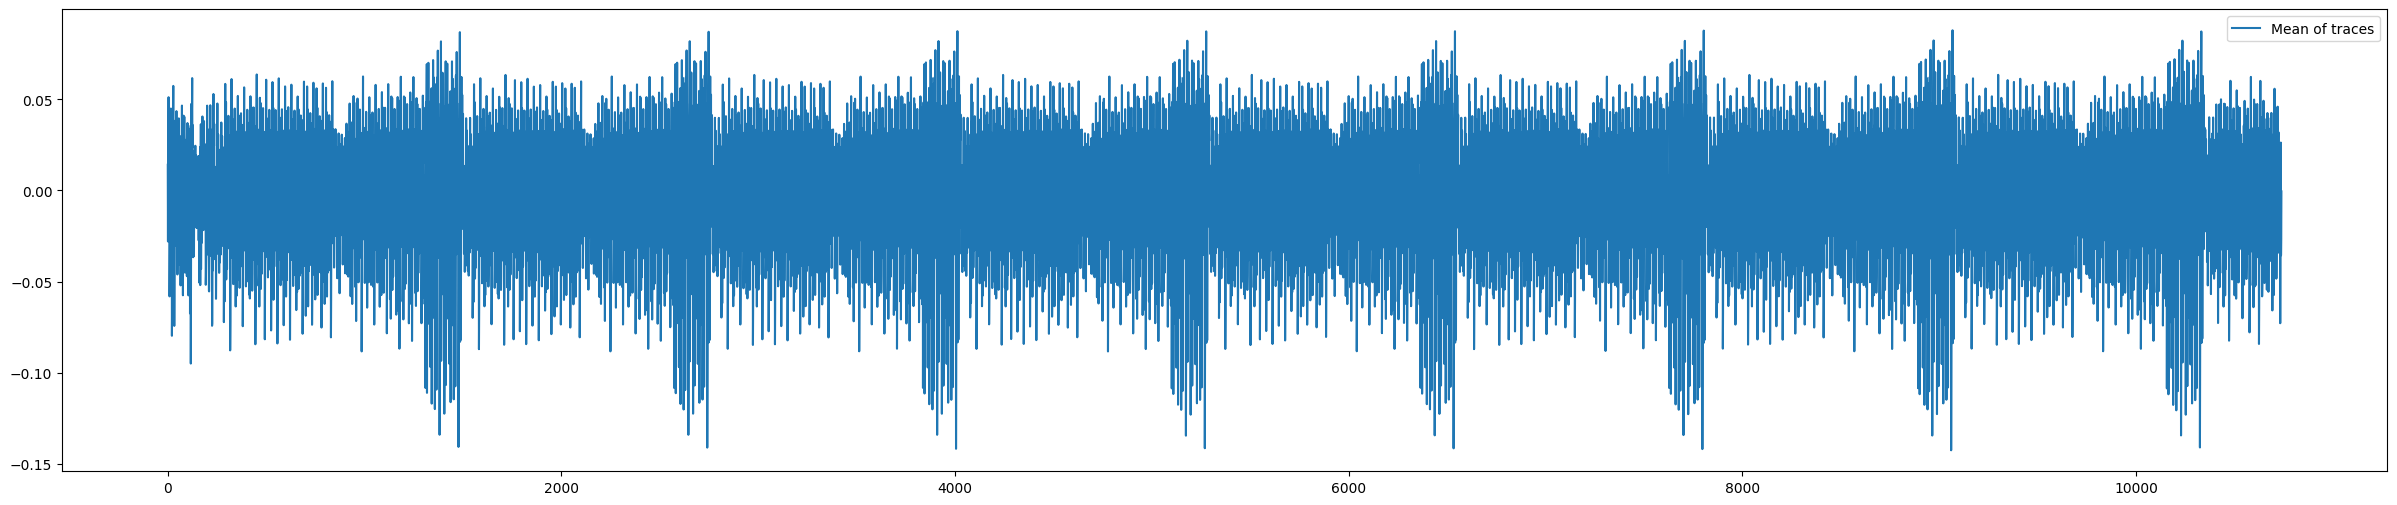

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30,6))
plt.plot(np.mean(traces, axis=0), label='Mean of traces')
plt.legend()

In [14]:
import scipy.stats
def cpa(traces, sensitive_data):
    num_sample = traces.shape[1]
    corelation_value = np.zeros(num_sample)
    for i in range(num_sample):
        corelation_value[i], _ = scipy.stats.pearsonr(traces[:, i], sensitive_data)
    return corelation_value


correlation = np.zeros((n, traces.shape[1]), dtype=np.int16)
for j in range(5):
    correlation[j] = cpa(traces, HW_all[:,j])    

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,6))
for j in range(5):
    plt.plot(np.abs(correlation[j]), label=f'Correlation with HW of {j}th coeff of ntt input')
plt.legend()

c:\Users\azade\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


Error in callback <function _draw_all_if_interactive at 0x000001F9B7E560C0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

c:\Users\azade\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


MemoryError: bad allocation

<Figure size 3000x600 with 1 Axes>